In [35]:
import pandas as pd
import numpy as np
import re

# Helper function

In [36]:
def data_cleaning(data,col_1):
    data[col_1]=data[col_1].apply(lambda x:x.lower())
    # Remove extra spaces
    data[col_1] = data[col_1].apply(lambda x: x.strip())
    return data[col_1]
# Add start and end tokens to target sequences
# data['sql'] = data['sql'].apply(lambda x : 'START_ '+ x + ' _END')

In [37]:
df = pd.read_csv('../input/train-data/train.csv')

In [38]:
df =  df.sample(n=40000,random_state=1)

In [39]:
df.head()

,question,sql
1661,What are all the 300 m group (mm) with a .308 ...,SELECT 300 m group (mm) FROM table WHERE .308 ...
7017,What are the alternative names of those satell...,SELECT Alt. Name FROM table WHERE Notes = Miss...
29628,Player than won in 2003?,SELECT Player FROM table WHERE Year(s) won = 2003
38300,What venue features an away side score of 11.1...,SELECT Venue FROM table WHERE Away team score ...
11053,Name the most races for flaps larger than 2.0,SELECT MAX Races FROM table WHERE FLaps > 2.0


In [40]:
df['question'] = data_cleaning(df,'question')

In [41]:
df['sql'] = df['sql'].apply(lambda x : 'START_ '+ x + ' _END')

In [42]:
data = pd.DataFrame()
data['input_data'] = df['question']
data['sql'] = df['sql']
df = data
df.head()

,input_data,sql
1661,what are all the 300 m group (mm) with a .308 ...,START_ SELECT 300 m group (mm) FROM table WHER...
7017,what are the alternative names of those satell...,START_ SELECT Alt. Name FROM table WHERE Notes...
29628,player than won in 2003?,START_ SELECT Player FROM table WHERE Year(s) ...
38300,what venue features an away side score of 11.1...,START_ SELECT Venue FROM table WHERE Away team...
11053,name the most races for flaps larger than 2.0,START_ SELECT MAX Races FROM table WHERE FLaps...


In [43]:
df['input_sent_length'] = df['input_data'].apply(lambda x:len(x.split()))
df['sql_sent_length'] = df['sql'].apply(lambda x:len(x.split()))
df.head()

,input_data,sql,input_sent_length,sql_sent_length
1661,what are all the 300 m group (mm) with a .308 ...,START_ SELECT 300 m group (mm) FROM table WHER...,22,22
7017,what are the alternative names of those satell...,START_ SELECT Alt. Name FROM table WHERE Notes...,19,17
29628,player than won in 2003?,START_ SELECT Player FROM table WHERE Year(s) ...,5,11
38300,what venue features an away side score of 11.1...,START_ SELECT Venue FROM table WHERE Away team...,10,13
11053,name the most races for flaps larger than 2.0,START_ SELECT MAX Races FROM table WHERE FLaps...,9,11


In [44]:
df.describe()

,input_sent_length,sql_sent_length
count,40000.000000,40000.000000
mean,11.638150,13.648075
std,4.498213,3.400495
min,3.000000,6.000000
25%,8.000000,11.000000
50%,11.000000,13.000000
75%,14.000000,15.000000
max,44.000000,84.000000


In [45]:
max(df['input_sent_length'])

44

In [46]:
max_input_sen_length = max(df['input_sent_length'])
max_output_sen_length = max(df['sql_sent_length'])

# rough-1


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
all_eng_words=set()
for eng in df['sql']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
t=Tokenizer(num_words=4000)
t.fit_on_texts(df['input_data'])
print(t.word_counts) # how many times it appear
print(t.word_index) # indexing words from vocab
print(t.word_docs)  # how many times appear in each doc
input_seq = t.texts_to_sequences(np.array(df['input_data']))
input_pad_seq = pad_sequences(input_seq,maxlen=max_input_sen_length,padding='post')
print(t.sequences_to_texts([input_pad_seq[0]]))
print(input_pad_seq[0])
sql_token = Tokenizer(4000)
sql_token.fit_on_texts(df['sql'])
print(sql_token.word_counts) # how many times it appear
print(sql_token.word_index) # indexing words from vocab
print(sql_token.word_docs)  # how many times appear in each doc
output_seq = sql_token.texts_to_sequences(np.array(df['sql']))
output_pad_seq = pad_sequences(output_seq,maxlen=max_input_sen_length,padding='post')
print(sql_token.sequences_to_texts([output_pad_seq[0]]))
print(output_pad_seq[0])



# rough-2


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras import regularizers
from keras import layers
from keras.layers import Embedding, Bidirectional, GlobalMaxPool1D
from gensim.models import KeyedVectors
from keras import regularizers
from keras import layers
from keras.layers import Embedding,RepeatVector
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense,Flatten,Conv2D,Conv1D,GlobalMaxPooling1D
from keras.layers import Input, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping
encoder_inp = Input(shape=(max_input_sen_length,))
encoder_embed = Embedding(4000,100,input_length=max_input_sen_length)(encoder_inp)
encoder_lstm_cell = LSTM(64,return_state=True)
encoder_output,encoder_state_h,encoder_state_c = encoder_lstm_cell(encoder_embed)
Creating LSTM decoder model and feeding the output states (h,c) of lstm of encoders
decoder_inp   = Input(shape=(max_input_sen_length,))
decoder_embed = Embedding(4000,100,input_length=max_input_sen_length)(decoder_inp)
decoder_lstm_cell = LSTM(64,return_sequences='True',return_state=True)
decoder_output,decoder_state_h,decoder_state_c = decoder_lstm_cell(decoder_embed,initial_state=[encoder_state_h,encoder_state_c])
decoder_dense_cell1 = Dense(max_input_sen_length,activation='relu')
decoder_d_output    = decoder_dense_cell1(decoder_output)
decoder_dense_cell2 = Dense(max_input_sen_length,activation='softmax')
decoder_output = decoder_dense_cell2(decoder_d_output)
model = Model([encoder_inp,decoder_inp],decoder_output) 
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Model

In [80]:
from keras.preprocessing.text import one_hot
from keras.backend import clear_session
import string
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding,Bidirectional
from keras.losses import sparse_categorical_crossentropy
import pickle

In [48]:
def token(sentances):
  # create tokenization
  text_token =Tokenizer(filters='$')
  text_token.fit_on_texts(sentances)
  return text_token.texts_to_sequences(sentances),text_token

In [81]:
def save_artifact(artifact,fname):
    # Open a file and use dump()
    with open(fname, 'wb') as file:

        # A new file will be created
        pickle.dump(artifact, file)

In [49]:
df_arr = np.array(df)

In [50]:
input_text_tokenized,input_text_tokenizer = token(df_arr[:,0])
output_text_tokenized,output_text_tokenizer = token(df_arr[:,1])

In [83]:
save_artifact(input_text_tokenizer,'input_text_tokenizer.pkl')
save_artifact(output_text_tokenizer,'output_text_tokenizer.pkl')

In [51]:
print('Maximum length spanish sentence: {}'.format(len(max(input_text_tokenized,key=len))))
print('Maximum length english sentence: {}'.format(len(max(output_text_tokenized,key=len))))

Maximum length spanish sentence: 44
Maximum length english sentence: 84


In [52]:
# Check language length
input_vocab = len(input_text_tokenizer.word_index) + 1
output_vocab = len(output_text_tokenizer.word_index) + 1
print("input_vocab vocabulary is of {} unique words".format(input_vocab))
print("output_vocab vocabulary is of {} unique words".format(output_vocab))

input_vocab vocabulary is of 42969 unique words
output_vocab vocabulary is of 33311 unique words


In [53]:
max_input_len = int(len(max(input_text_tokenized,key=len)))
max_output_len = int(len(max(output_text_tokenized,key=len)))

input_pad_sentence = pad_sequences(input_text_tokenized, max_input_len, padding = "post")
output_pad_sentence = pad_sequences(output_text_tokenized, max_output_len, padding = "post")
pad_sequences
# Reshape data
input_pad_sentence = input_pad_sentence.reshape(*input_pad_sentence.shape, 1)
output_pad_sentence = output_pad_sentence.reshape(*output_pad_sentence.shape, 1)

In [54]:
temp =[]
for i in output_pad_sentence[1:]:
    temp.append(i)

In [55]:
output_pad_sentence_2 = np.array(temp)

In [57]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(input_pad_sentence,output_pad_sentence,test_size=0.05,random_state=2)

In [66]:
callback = [tf.keras.callbacks.EarlyStopping(patience=3),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3)]

In [67]:

clear_session()
input_sequence = Input(shape=(max_input_len,))
embedding = Embedding(input_dim=input_vocab, output_dim=128,)(input_sequence)
encoder = Bidirectional(LSTM(100, return_sequences=False,dropout=0.2))(embedding)
r_vec = RepeatVector(max_output_len)(encoder)
decoder = Bidirectional(LSTM(100, return_sequences=True, dropout=0.2))(r_vec)
logits = TimeDistributed(Dense(output_vocab))(decoder)
enc_dec_model = Model(input_sequence, Activation('softmax')(logits))
enc_dec_model.compile(loss=sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
enc_dec_model.summary()
ep = 100
batch_size=164
model_results = enc_dec_model.fit(x_train, y_train, batch_size=batch_size, epochs=ep,validation_data=(x_test,y_test),callbacks=[callback])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 44, 128)           5500032   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               183200    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 84, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 84, 200)           240800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 84, 200)           240800    
_________________________________________________________________
time_distributed (TimeDistri (None, 84, 33311)         669551

In [68]:
input_sentences = df_arr[:,0]
output_sentences = df_arr[:,1]
def logits_to_sentence(logits, tokenizer):

    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>' 
    sen = ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])
    sen = sen.replace('<empty>','')
    sen = sen.replace('start','')
    sen = sen.replace('end','')
    return sen



In [ ]:
logits_to_sentence()

In [ ]:
input_pad_sentence = pad_sequences(input_text_tokenized, max_input_len, padding = "post")
output_pad_sentence = pad_sequences(output_text_tokenized, max_output_len, padding = "post")

In [98]:
max_input_len,max_output_len

(44, 84)

In [106]:
def convertQuest2Qry(question):
    question = [question]
    model_input = pad_sequences(input_text_tokenizer.texts_to_sequences(question),44,padding='post')
    qry = logits_to_sentence(enc_dec_model.predict(model_input)[0],output_text_tokenizer)
    return qry

In [108]:
convertQuest2Qry("what was the position of the player from butler high school?")

'_ select position from table where player = = york school _                                                                        '

In [99]:
model_input = pad_sequences(input_text_tokenizer.texts_to_sequences([sql]),44,padding='post')

In [102]:
logits_to_sentence(enc_dec_model.predict(model_input)[0],output_text_tokenizer)

'_ select location from from table where = = _                                                                          '

In [ ]:
padded_input = 

In [69]:
for i in [81,47,75,4781,4775]:
    print("The Input sentence is: {}".format(input_sentences[i]))
    print("The SQL Query is: {}".format(output_sentences[i]))
    print('The predicted SQL Query is :')
    print(logits_to_sentence(enc_dec_model.predict(input_pad_sentence[i:i+1])[0], output_text_tokenizer))
    print('--'*20)

The Input sentence is: what is the style of the dance choreographed by nacho pop with result of safe?
The SQL Query is: START_ SELECT Style FROM table WHERE Results = safe AND Choreographer = nacho pop _END
The predicted SQL Query is :
_ select year from table where year = nominated and and = = _ _                                                                     
----------------------------------------
The Input sentence is: what is the start address when the network number bit field is 16?
The SQL Query is: START_ SELECT Start address FROM table WHERE Size of network number bit field = 16 _END
The predicted SQL Query is :
_ select to doubles from table where class = = = and and = = _                                                                    
----------------------------------------
The Input sentence is: what's the overall rank with viewers (m) of 7.44
The SQL Query is: START_ SELECT Overall Rank FROM table WHERE Viewers (m) = 7.44 _END
The predicted SQL Query is :
_ sele

In [62]:
enc_dec_model.save('best_wikisql_model.h5')

In [63]:
import seaborn as sns


<AxesSubplot:>

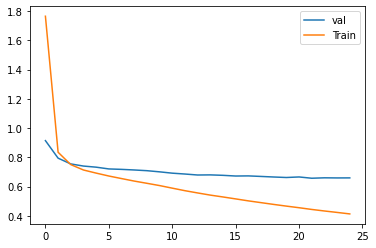

In [70]:
sns.lineplot(x=range(0,25),y=model_results.history['val_loss'],label='val')
sns.lineplot(x=range(0,25),y=model_results.history['loss'],label='Train')

<AxesSubplot:>

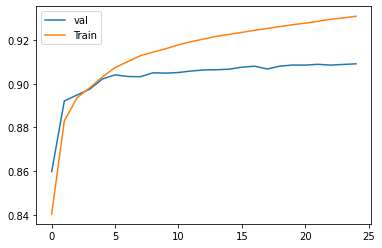

In [71]:
sns.lineplot(x=range(0,25),y=model_results.history['val_accuracy'],label='val')
sns.lineplot(x=range(0,25),y=model_results.history['accuracy'],label='Train')